Rayleigh-Taylor instability
======

<table><tr><td><img src='./pic/kaus2010_RT_image0000.png'></td></tr></table>
Initial model setup with buoyancy perturbation.

This notebook models the Rayleigh-Taylor instability outlined in van Kaus *et al.* (2010) for the FSSA algorithm test. 

The system of equations is given by

$$
    \nabla \cdot \left( \eta \nabla \dot\varepsilon \right) - \nabla p = -\rho g \mathbf{\hat z}
$$

$$
    \nabla \cdot \mathbf{v} = 0
$$

**Keywords:** particle swarms, Stokes system, advective diffusive systems

**References**

- Kaus, B.J.P., et al., A stabilization algorithm for geodynamic numerical simulations with a free surface. Phys.
Earth Planet. In. (2010), doi:10.1016/j.pepi.2010.04.007

In [1]:
import underworld as uw
from underworld import function as fn
import underworld.visualisation as vis
from underworld.scaling import units as u
from underworld.scaling import dimensionalise 
from underworld.scaling import non_dimensionalise as nd
import math
import numpy as np
import os

In [2]:
# output
input_path  = 'input/05_Rayleigh_Taylor/'
output_path = 'output/'

model_end_step   = 10
res              = 64
stokes_inner_tol = 1e-6
stokes_outer_tol = 1e-5

# search and build, if required, an output path
if uw.mpi.rank==0:
    try:
        if not os.path.exists("./"+output_path+"/"):
            os.makedirs("./"+output_path+'/')
    except:
        raise

In [3]:
# build reference units
KL_meters   = 500 * u.kilometer
K_viscosity = 1e20  * u.pascal * u.second
K_density   = 3200 * u.kilogram / u.meter**3

# compute dependent scaling units 
KT_seconds = 5*u.kiloyear
KM_kilograms = KT_seconds * KL_meters * K_viscosity
#KM_kilograms = K_density * KL_meters**3
#KT_seconds   = KM_kilograms / ( KL_meters * K_viscosity )
K_substance  = 1. * u.mole
#Kt_degrees   = 1. * u.kelvin

scaling_coefficients = uw.scaling.get_coefficients()
scaling_coefficients["[length]"]      = KL_meters.to_base_units()
#scaling_coefficients["[temperature]"] = Kt_degrees.to_base_units()
scaling_coefficients["[time]"]        = KT_seconds.to_base_units()
scaling_coefficients["[mass]"]        = KM_kilograms.to_base_units()

gravity   = nd( 9.81 * u.meter / u.second**2)


ymaxCoord = nd(0.* u.kilometer)
yminCoord = nd(-500* u.kilometer)
xmaxCoord = nd(250* u.kilometer)
xminCoord = nd(-250* u.kilometer)

In [4]:
# build mesh and mesh variables
resolution       = (64,64)
mesh = uw.mesh.FeMesh_Cartesian( elementType = 'Q1/dQ0', 
                                 elementRes  = resolution, 
                                 minCoord    = [xminCoord,yminCoord], 
                                 maxCoord    = [xmaxCoord,ymaxCoord],
                                 periodic    = [False, False] )

velocityField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

In [5]:
# Create a swarm.
swarm = uw.swarm.Swarm( mesh=mesh,particleEscape=True)

# Create a data variable. It will be used to store the material index of each particle.
materialIndex = swarm.add_variable( dataType="int", count=1 )

# Create a layout object, populate the swarm with particles.
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )
pop_control = uw.swarm.PopulationControl(swarm,aggressive=True,splitThreshold=0.15, maxDeletions=2,maxSplits=10,
                                                particlesPerCell=20)

In [6]:
# define these for convience. 
denseIndex = 0
lightIndex = 1

# material perturbation from van Keken et al. 1997
wavelength = nd(xmaxCoord*2)
amplitude  = nd(5*u.kilometer)
offset     = nd(-100.*u.kilometer)
k = 2. * math.pi / wavelength

# Create function to return particle's coordinate
coord = fn.coord()

# Define the material perturbation, a function of the x coordinate (accessed by `coord[0]`).
perturbationFn = offset + amplitude*fn.math.cos( k*coord[0] )

# Setup the conditions list. 
# If z is less than the perturbation, set to lightIndex.
conditions = [ ( perturbationFn > coord[1] , lightIndex ),
               (                      True , denseIndex ) ]

# The swarm is passed as an argument to the evaluation, providing evaluation on each particle.
# Results are written to the materialIndex swarm variable.
materialIndex.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)


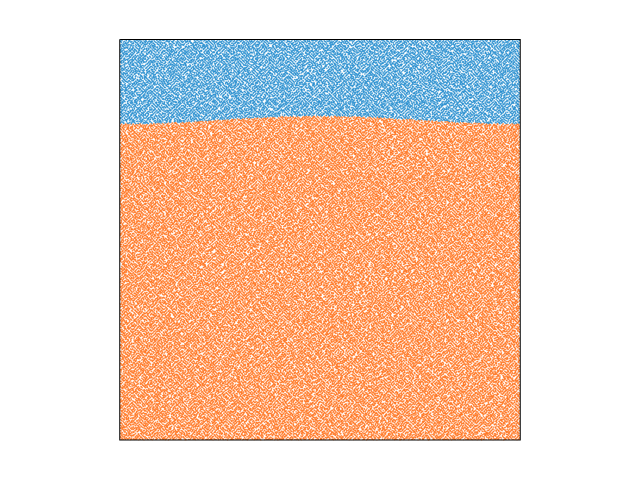

'output/image_0.png'

In [7]:
fig1 = vis.Figure() #title="Material", figsize=(400,400), quality=2, rulers=True)
fig1.Points(swarm, materialIndex, fn_size=2.,discret=True,colourBar = False) 
fig1.VectorArrows(mesh, velocityField) 
fig1.show()
fig1.save_image(output_path+"image_0")

In [8]:
light_density = nd(3200 * u.kilogram / u.meter**3)
dense_density = nd(3300 * u.kilogram / u.meter**3)
light_viscosity = nd(1e20 * u.pascal * u.second)
dense_viscosity = nd(1e21 * u.pascal * u.second)


# Set a density of '0.' for light material, '1.' for dense material.
densityMap   = { lightIndex:light_density, denseIndex:dense_density }
densityFn    = fn.branching.map( fn_key = materialIndex, mapping = densityMap )

# Set a viscosity value of '1.' for both materials.
viscosityMap = { lightIndex:light_viscosity, denseIndex:dense_viscosity }
fn_viscosity  = fn.branching.map( fn_key = materialIndex, mapping = viscosityMap )

# Define a vertical unit vector using a python tuple.
z_hat = ( 0.0, 1.0 )

# Create buoyancy force vector
buoyancyFn = -densityFn*z_hat

In [9]:
# Construct node sets using the mesh specialSets
iWalls = mesh.specialSets["Left_VertexSet"]   + mesh.specialSets["Right_VertexSet"]
jWalls = mesh.specialSets["Bottom_VertexSet"] + mesh.specialSets["Top_VertexSet"]
botWalls = mesh.specialSets["Bottom_VertexSet"]
allWalls = iWalls + jWalls

#for test FSSA
#Side boundaries are free slip, 
#the lower boundary is no-slip 
#and the upper boundary is a free surface
stokesBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                             indexSetsPerDof = (iWalls+botWalls, botWalls) )


# # for test free slip top
# stokesBC = uw.conditions.DirichletCondition( variable      = velocityField, 
#                                              indexSetsPerDof = (iWalls+botWalls,jWalls) )

In [10]:
stokes = uw.systems.Stokes( velocityField = velocityField, 
                            pressureField = pressureField,
                            conditions    = stokesBC,
                            fn_viscosity  = fn_viscosity, 
                            fn_bodyforce  = buoyancyFn )

solver = uw.systems.Solver( stokes )

# Optional solver settings
if(uw.mpi.size==1):
    solver.set_inner_method("lu")
solver.set_inner_rtol(stokes_inner_tol) 
solver.set_outer_rtol(stokes_outer_tol) 

# Create a system to advect the swarm
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

In [11]:
from scipy.interpolate import interp1d
import underworld as uw
from mpi4py import MPI as _MPI

comm = _MPI.COMM_WORLD
rank = comm.rank
size = comm.size

class FreeSurfaceProcessor(object):
    """FreeSurfaceProcessor"""

    def __init__(self):
        """Create a Freesurface processor


        """

        # Create the tools
        self.TField = mesh.add_variable(nodeDofCount=1)
        self.TField.data[:, 0] = mesh.data[:, 1]

        self.top = mesh.specialSets["Top_VertexSet"]
        self.bottom = mesh.specialSets["Bottom_VertexSet"]

        # Create boundary condition
        self._conditions = uw.conditions.DirichletCondition(
            variable=self.TField,
            indexSetsPerDof=(self.top + self.bottom,))

        # Create Eq System
        self._system = uw.systems.SteadyStateHeat(
            temperatureField=self.TField,
            fn_diffusivity=1.0,
            conditions=self._conditions)

        self._solver = uw.systems.Solver(self._system)

    def _solve_sle(self):
        self._solver.solve()

    def _advect_surface(self, dt):

        if self.top:
            # Extract top surface
            x =  mesh.data[self.top.data][:, 0]
            y =  mesh.data[self.top.data][:, 1]

            # Extract velocities from top
            vx = velocityField.data[self.top.data][:, 0]
            vy = velocityField.data[self.top.data][:, 1]

            # Advect top surface
            x2 = x + vx * nd(dt)
            y2 = y + vy * nd(dt)

            # Spline top surface
            f = interp1d(x2, y2, kind='cubic', fill_value='extrapolate')

            self.TField.data[self.top.data, 0] = f(x)
        comm.Barrier()
        self.TField.syncronise()

    def _update_mesh(self):

        with  mesh.deform_mesh():
            # Last dimension is the vertical dimension
             mesh.data[:, -1] = self.TField.data[:, 0]

    def solve(self, dtime):
        """ Advect free surface through dt and update the mesh """

        # First we advect the surface
        self._advect_surface(dtime)
        # Then we solve the system of linear equation
        self._solve_sle()
        # Finally we update the mesh
        self._update_mesh()

In [12]:
# Initialise time and timestep.
time = 0.

step = 0

# parameters for output
outputEvery  = 1
timeVal     = []
vrmsVal     = []

# Save mesh and retain file handle for future xdmf creation
meshFileHandle = mesh.save(output_path+"Mesh.h5")

In [13]:
# define an update function
def update():   
    dt = advector.get_max_dt() # retrieve the maximum possible timestep from the advection system.
    advector.integrate(dt, update_owners=False)
    freesuface =  FreeSurfaceProcessor()
    freesuface.solve(dt)

    pop_control.repopulate()
    swarm.update_particle_owners()

    return time+dt, step+1, dt

In [14]:
while step < model_end_step:

    # Get solution
    solver.solve()
    
    # Calculate the RMS velocity.
    vrms = stokes.velocity_rms()

    # Record values into arrays
    if(uw.mpi.rank==0):
        vrmsVal.append(vrms)
        timeVal.append(time)
     
    time, step, dt = update()
    if(uw.mpi.rank==0):
        string = "{:4d}, {:.3e},{:.3e},{:.3e}".format(step,dimensionalise(dt, u.kiloyear),dimensionalise(time, u.kiloyear),dimensionalise(vrms,u.meter/u.year)) 
        print(string)
                                                   
    # Output to disk
    if step%outputEvery == 0:
        #if(uw.mpi.rank==0):
        #    print('step = {0:6d}; time = {1:.3e}; v_rms = {2:.3e}'.format(step,time,vrms))

        filename = output_path+"/velocityField."+str(step)
        vFH      = velocityField.save(filename+".h5")
        velocityField.xdmf( filename, vFH, "velocity", meshFileHandle, "Mesh", time )
        
        filename = output_path+"/pressureField."+str(step)
        pFH      = pressureField.save(filename+".h5")
        pressureField.xdmf(filename, pFH, "pressure", meshFileHandle, "Mesh", time )
        
        outputFilename = output_path+"image"+str(step).zfill(4)
        fig1.save_image(outputFilename)

    # We are finished with current timestep, update.
    #updateMesh()

   1, 1.049e+20 kiloyear,1.049e+20 kiloyear,1.561e-20 meter / year
   2, 4.830e+18 kiloyear,1.097e+20 kiloyear,3.008e-19 meter / year
   3, 1.948e+19 kiloyear,1.292e+20 kiloyear,6.587e-20 meter / year
   4, 1.843e+18 kiloyear,1.310e+20 kiloyear,8.888e-19 meter / year
   5, 2.435e+18 kiloyear,1.334e+20 kiloyear,7.124e-19 meter / year
   6, 1.935e+18 kiloyear,1.354e+20 kiloyear,9.808e-19 meter / year
   7, 2.206e+18 kiloyear,1.376e+20 kiloyear,8.778e-19 meter / year
   8, 1.931e+18 kiloyear,1.395e+20 kiloyear,1.018e-18 meter / year
   9, 2.175e+18 kiloyear,1.417e+20 kiloyear,9.084e-19 meter / year
  10, 1.929e+18 kiloyear,1.436e+20 kiloyear,1.028e-18 meter / year



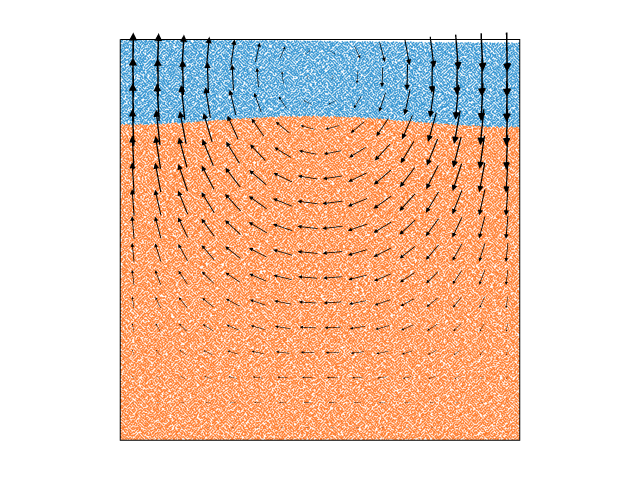

In [15]:
fig1.show()

In [16]:
# viscosityRatio = dense_viscosity / light_viscosity


# if uw.mpi.rank==0:
    
#     maxIndex = np.argmax(vrmsVal)

#     print('Viscosity ratio = {0:.2f}'.format(viscosityRatio))
#     print('    t(max vrms) = {0:.2f}'.format(timeVal[maxIndex]))
#     print('           vrms = {0:.4e}'.format(vrmsVal[maxIndex]))
    
#     # output a summary file with benchmark values (useful for parallel runs)
#     np.savetxt(output_path+'summary.txt', [viscosityRatio, timeVal[maxIndex], vrmsVal[maxIndex]])

In [17]:
# if uw.mpi.size == 1:
#     if   viscosityRatio == 1.0 :
#         data = np.loadtxt(input_path+'VrmsCaseA.txt', unpack=True )
#     elif viscosityRatio == 0.1 :
#         data = np.loadtxt(input_path+'VrmsCaseB.txt', unpack=True )
#     elif viscosityRatio == 0.01 :
#         data = np.loadtxt(input_path+'VrmsCaseC.txt', unpack=True )
#     else :
#         print('No specific data found - default to Case A')
#         data = np.loadtxt(input_path+'VrmsCaseA.txt', unpack=True )

#     # Load into data arrays to compare with timevals and vrmsvals from above.
#     timeCompare, vrmsCompare = data[0], data[1] 
#     # These can be copied onto timevals and vrmsvals to skip running the time loop.    
#     uw.utils.matplotlib_inline()

#     import matplotlib.pyplot as pyplot
#     fig = pyplot.figure()
#     fig.set_size_inches(12, 6)
#     ax = fig.add_subplot(1,1,1)
#     ax.plot(timeCompare, vrmsCompare, color = 'black') 
#     ax.plot(timeVal, vrmsVal, color = 'red', marker=".", markersize=10) 
#     ax.set_xlabel('Time')
#     ax.set_ylabel('RMS velocity')
#     ax.set_xlim([0.0,1000.0])